# Mean Reversion - Pairs Trading 

This otebook will be the first glance on the subject of Pairs Trading It is a popular strategy in quantitative finance that aims to take advantage of mean reversion in the prices of two related assets. The concept behind pairs trading is based on the belief that, over time, the prices of two assets that are historically correlated will tend to move back towards their average or equilibrium relationship when they diverge.  

The mean reversion aspect of pairs trading suggests that if the prices of the two assets move apart from their historical relationship, there is a higher probability that they will eventually converge back to their average relationship. This provides an opportunity for traders to profit by taking opposite positions on the two assets.

The technique is to find high correlation $r$ between Long and Short Pairs ($L$ & $S$, always r > 0.85). If there is high $r$ and the prices move in opposite directions, the capitalization on that behavior may be considered.

In [4]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.5 MB/s eta 0:00:00


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import pandas_datareader as pdr
from datetime import datetime as dt
import statsmodels.tsa.stattools as ts

import yfinance as yf
yf.pdr_override()

import warnings
warnings.filterwarnings('ignore')

In [16]:
def get_historical_Data(tickers):
    """This function returns a pd dataframe with all of the adjusted closing information"""
    data = pd.DataFrame()
    names = list()
    for i in tickers:
        data = pd.concat([data, pd.DataFrame(yf.download(i, start=dt(2020, 1, 1), end=dt.now()).iloc[:,4])], axis = 1)
        names.append(i)
    data.columns = names
    return data

ticks = ["DPZ", "AAPL", "GOOG", "AMD", "GME", "SPY", "NFLX", "BA", "WMT","GS","XOM","NKE","BRK-B", "MSFT"] #Name of company (Dominos pizza)
df = get_historical_Data(ticks)
print(df.shape)
# Most Recent Data
df.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(849, 14)


,DPZ,AAPL,GOOG,AMD,GME,SPY,NFLX,BA,WMT,GS,XOM,NKE,BRK-B,MSFT
Date,,,,,,,,,,,,,,
2023-05-10,306.890015,173.320267,112.279999,97.019997,20.760000,412.850006,335.420013,200.839996,152.550003,322.549988,106.813141,123.510002,322.989990,312.309998
2023-05-11,306.929993,173.510010,116.900002,97.099998,20.879999,412.130005,344.760010,201.839996,153.119995,320.720001,104.879921,122.220001,322.640015,310.109985
2023-05-12,307.579987,172.570007,117.919998,95.260002,20.690001,411.589996,339.890015,200.699997,153.070007,319.500000,104.870003,120.209999,322.489990,308.970001
2023-05-15,307.850006,172.070007,116.959999,97.400002,21.620001,413.010010,335.890015,202.770004,151.880005,322.070007,105.070000,119.830002,323.529999,309.459991
2023-05-16,301.850006,172.070007,120.089996,101.480003,21.990000,410.250000,333.750000,200.869995,149.779999,320.809998,102.519997,116.480003,323.750000,311.739990


<AxesSubplot: >

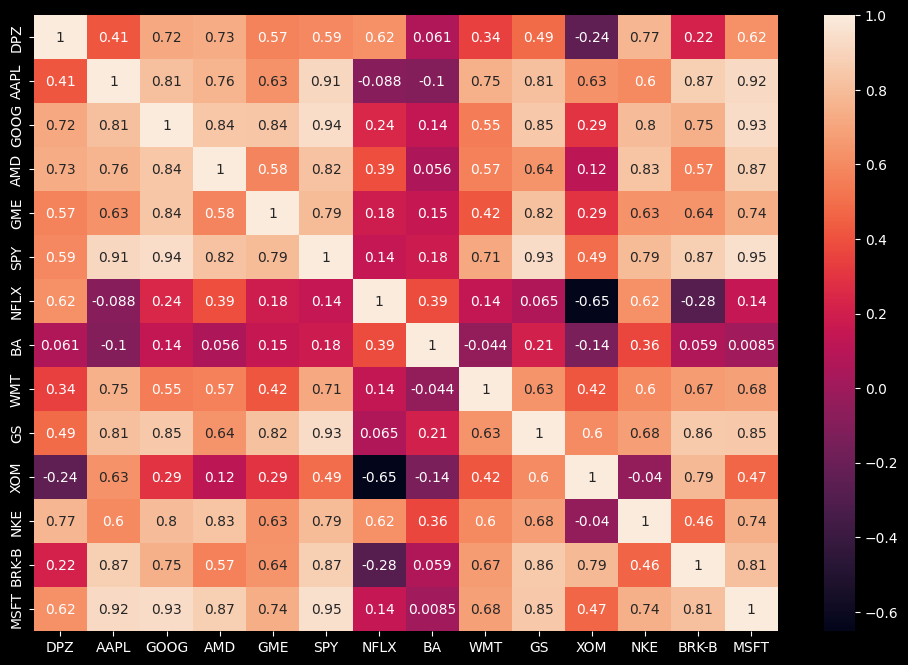

In [17]:
plt.figure(figsize=(12, 8))
corrmat = df.corr()
sns.heatmap(corrmat, annot=True)

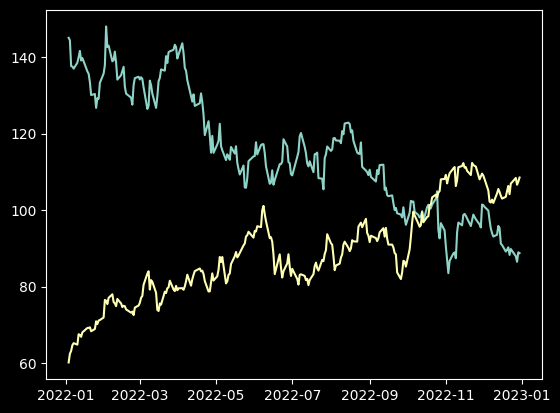

In [10]:
plt.plot(df.loc[:, 'GOOG'])
plt.plot(df.loc[:, 'XOM'])

In [26]:
raw_pairs = {}
pairs = {}
drop = False
for row in corrmat.index:
    for col in corrmat.columns:
        if 1 > corrmat.loc[row, col] > 0.845:
            raw_pairs[f'{row}&{col}'] = corrmat.loc[row, col]
            
raw_pairs = dict(sorted(raw_pairs.items(), key=lambda x: x[1], reverse=True))


for key, value in raw_pairs.items():
    if not drop:
        pairs[key] = value
    drop = not drop

pairs

{'SPY&MSFT': 0.952985080338218,
 'GOOG&SPY': 0.938996622802502,
 'GOOG&MSFT': 0.9332064196532153,
 'SPY&GS': 0.932291486251197,
 'AAPL&MSFT': 0.9181663141266654,
 'AAPL&SPY': 0.9130770709840741,
 'AAPL&BRK-B': 0.8740792499874732,
 'SPY&BRK-B': 0.8718001905091939,
 'AMD&MSFT': 0.8710001421185383,
 'GS&BRK-B': 0.8563359468743663,
 'GS&MSFT': 0.8512626285699799,
 'GOOG&GS': 0.8495922383265556}

## Plotting and deducing

In the graphic below, all stocks are repeating themselves and are highly correlated, but it is more interesting to take the pair of stocks that are insertecting the most often. In this particular stocks, MSFT and BRK-B will be the use case.

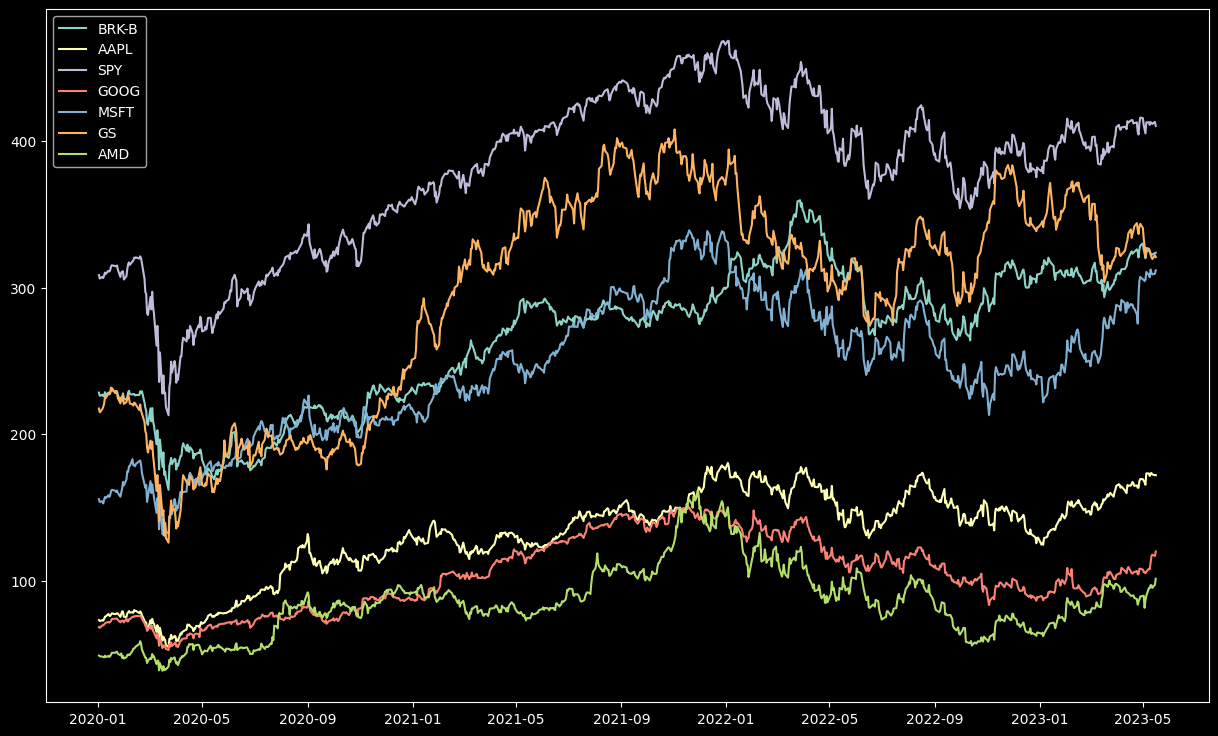

In [33]:
args=[]
for key in pairs.keys():
    raw_args = key.split('&')
    args += raw_args    

args = list(set(args))

plt.figure(figsize=(15, 9))
for arg in args:
    plt.plot(df.loc[:, arg], label=arg)
    
plt.legend()

Text(0.5, 1.0, 'Spread between BRK-B and MSFT')

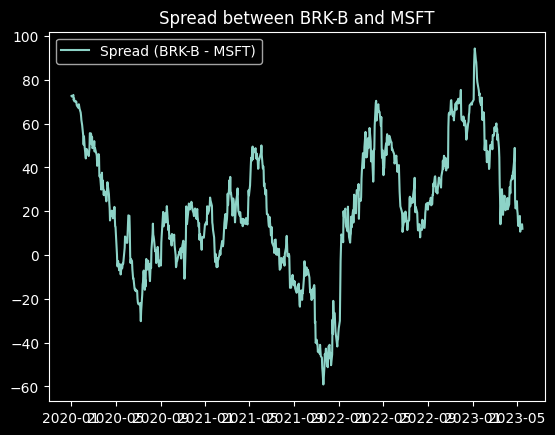

In [36]:
BRK_B = df.loc[:, 'BRK-B']
MSFT = df.loc[:, 'MSFT']
plt.plot(BRK_B - MSFT, label = 'Spread (BRK-B - MSFT)')
plt.legend()
plt.title("Spread between BRK-B and MSFT")

## Observations

It is a must to check the cointegration value. Assuming that the H0 is 'no cointegration' hypthesis. The cointegration test is a technique to find a potential correlation in time series for a long term, and it determines if the spread between the two assets are constant over time. Again, H0 transforms to 'Spreead between series are non-stationary'.

The tests used are the augmented Engle-Granger two-step cointegration test and augmented dickey-fuller test, and it is desirable to get P < 0.05 to affirm that cointegration exists

In [43]:
res = ts.coint(BRK_B, MSFT)
print(f'Engle-Granger failed, beacause P value is {res[1]}')
BRK_B_ADF = ts.adfuller(BRK_B)
MSFT_ADF = ts.adfuller(MSFT)
Spread_ADF = ts.adfuller(BRK_B - MSFT)
Ratio_ADF = ts.adfuller(BRK_B / MSFT)
print('P value for the BRK_B Adfuller Test is', BRK_B_ADF[1])
print('P value for the MSFT Adfuller Test is', MSFT_ADF[1])
print('P value for the BRK_B-MSFT Adfuller Test is', Spread_ADF[1])
print('P value for the BRK_B/MSFT Adfuller Test is', Ratio_ADF[1])

# Results: can only claim stationary for the spread (since P value < 0.05). 
#This suggests a constant mean over time.
# Therefore, the two series are cointegrated.

Engle-Granger failed, beacause P value is 0.42029553682811865
P value for the BRK_B Adfuller Test is 0.7612038324219577
P value for the MSFT Adfuller Test is 0.4669888603136994
P value for the BRK_B-MSFT Adfuller Test is 0.10342632518969258
P value for the BRK_B/MSFT Adfuller Test is 0.019785165297581394


Text(0.5, 1.0, 'Price Ratio between BRK and MSFT')

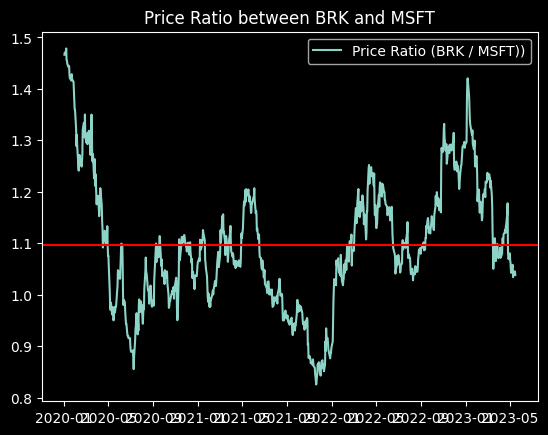

In [56]:
ratio = BRK_B / MSFT
plt.plot(ratio, label = 'Price Ratio (BRK / MSFT))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio between BRK and MSFT")

Text(0.5, 1.0, 'Z score of Ratio of Berkshire to MSFT')

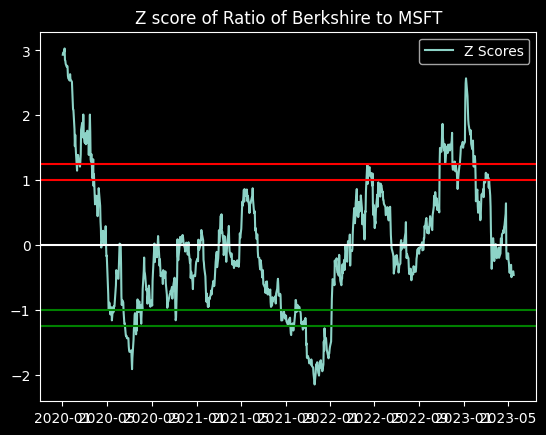

In [55]:
df_zscore = (ratio - ratio.mean())/ratio.std()

plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'white')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of Berkshire to MSFT')

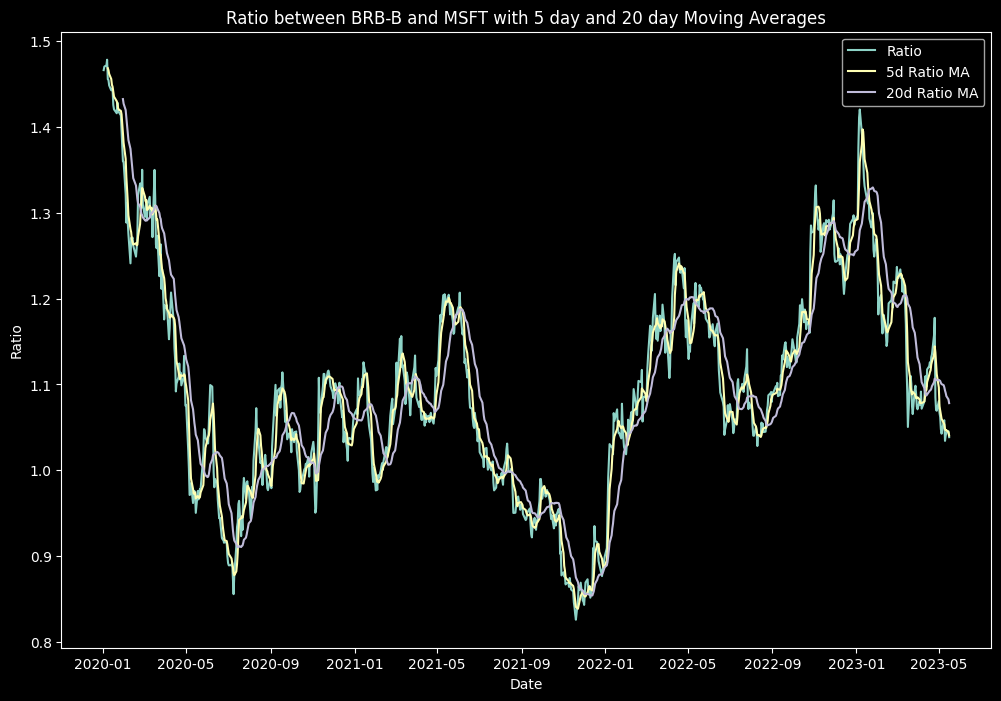

In [58]:
plt.figure(figsize=(12, 8))
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Ratio between BRB-B and MSFT with 5 day and 20 day Moving Averages')
plt.show()

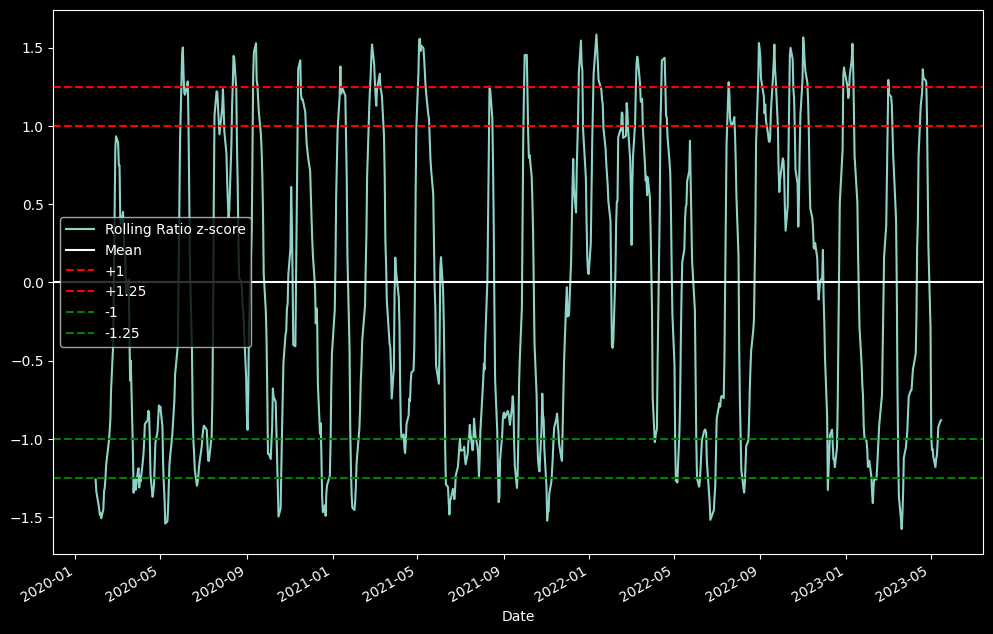

In [62]:
plt.figure(figsize=(12, 8))
zscore_20_5.plot()
plt.axhline(0, color='white')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

Text(0.5, 1.0, 'Relationship BRK to MSFT')

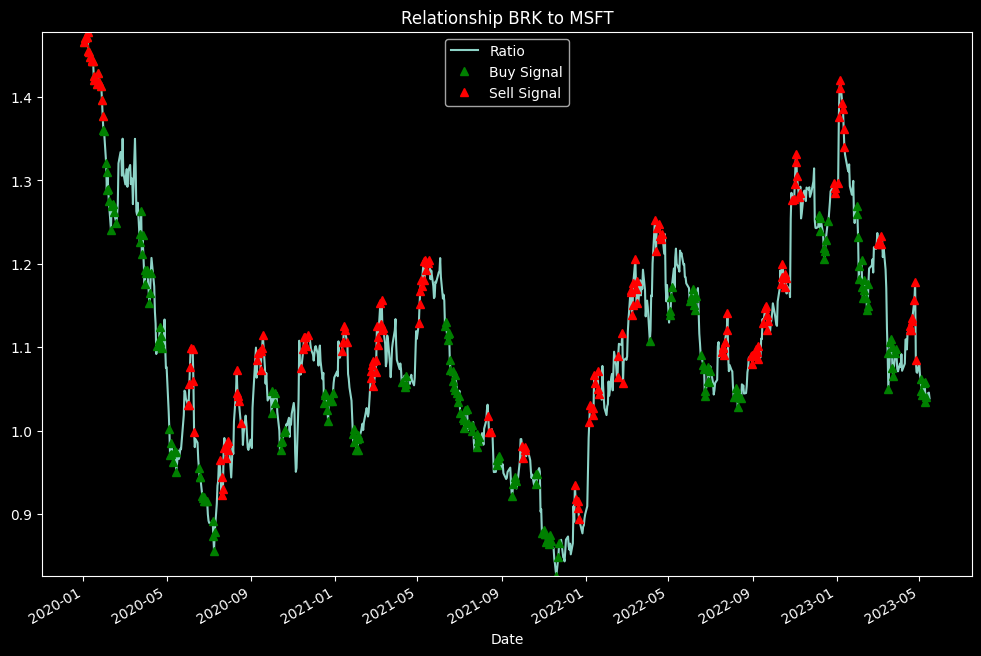

In [63]:
plt.figure(figsize=(12, 8))
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship BRK to MSFT')